In [ ]:
from scipy.stats import iqr,skew,kurtosis
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


import numpy as np
from scipy import interpolate, signal
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import matplotlib.patches as mpatches
from collections import OrderedDict

def frequencyDomain(RRints,tmStamps, band_type = None, lf_bw = 0.11, hf_bw = 0.1, plot = 0):
    
    #Remove ectopic beats
    #RR intervals differing by more than 20% from the one proceeding it are removed
    NNs = []
    tss = []
    for c, rr in enumerate(RRints):        
        if abs(rr - RRints[c-1]) <= 0.20 * RRints[c-1]:
            NNs.append(rr)
            tss.append(tmStamps[c])
            
            
    frequency_range = np.linspace(0.001, 1, 10000)
    NNs = np.array(NNs)
    NNs = NNs - np.mean(NNs)
    result = signal.lombscargle(tss, NNs, frequency_range)
        
    #Pwelch w/ zero pad     
    fxx = frequency_range 
    pxx = result 
    
    vlf= (0.003, 0.04)
    lf = (0.04, 0.15)
    hf = (0.15, 0.4)
    
    plot_labels = ['VLF', 'LF', 'HF']
        
    if band_type == 'adapted':     
            
        vlf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])]))[0][0]] 
        lf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])]))[0][0]]
        hf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])]))[0][0]]
    
        peak_freqs =  (vlf_peak, lf_peak, hf_peak) 
            
        hf = (peak_freqs[2] - hf_bw/2, peak_freqs[2] + hf_bw/2)
        lf = (peak_freqs[1] - lf_bw/2, peak_freqs[1] + lf_bw/2)   
        vlf = (0.003, lf[0])
        
        if lf[0] < 0:
            print('***Warning***: Adapted LF band lower bound spills into negative frequency range')
            print('Lower thresold of LF band has been set to zero')
            print('Adjust LF and HF bandwidths accordingly')
            lf = (0, lf[1])        
            vlf = (0, 0)
        elif hf[0] < 0:
            print('***Warning***: Adapted HF band lower bound spills into negative frequency range')
            print('Lower thresold of HF band has been set to zero')
            print('Adjust LF and HF bandwidths accordingly')
            hf = (0, hf[1])        
            lf = (0, 0)        
            vlf = (0, 0)
            
        plot_labels = ['Adapted_VLF', 'Adapted_LF', 'Adapted_HF']

    df = fxx[1] - fxx[0]
    vlf_power = np.trapz(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])], dx = df)      
    lf_power = np.trapz(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])], dx = df)            
    hf_power = np.trapz(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])], dx = df)             
    totalPower = vlf_power + lf_power + hf_power
    
    #Normalize and take log
    vlf_NU_log = np.log((vlf_power / (totalPower - vlf_power)) + 1)
    lf_NU_log = np.log((lf_power / (totalPower - vlf_power)) + 1)
    hf_NU_log = np.log((hf_power / (totalPower - vlf_power)) + 1)
    lfhfRation_log = np.log((lf_power / hf_power) + 1)   
    
    freqDomainFeats = {'VLF_Power': vlf_NU_log, 'LF_Power': lf_NU_log,
                       'HF_Power': hf_NU_log, 'LF/HF': lfhfRation_log}
                       
    if plot == 1:
        #Plot option
        freq_bands = {'vlf': vlf, 'lf': lf, 'hf': hf}
        freq_bands = OrderedDict(sorted(freq_bands.items(), key=lambda t: t[0]))
        colors = ['lightsalmon', 'lightsteelblue', 'darkseagreen']
        fig, ax = plt.subplots(1)
        ax.plot(fxx, pxx, c = 'grey')
        plt.xlim([0, 0.40])
        plt.xlabel(r'Frequency $(Hz)$')
        plt.ylabel(r'PSD $(s^2/Hz$)')
        
        for c, key in enumerate(freq_bands):
            ax.fill_between(fxx[min(np.where(fxx >= freq_bands[key][0])[0]): max(np.where(fxx <= freq_bands[key][1])[0])],
                            pxx[min(np.where(fxx >= freq_bands[key][0])[0]): max(np.where(fxx <= freq_bands[key][1])[0])],
                            0, facecolor = colors[c])
            
        patch1 = mpatches.Patch(color = colors[0], label = plot_labels[2])
        patch2 = mpatches.Patch(color = colors[1], label = plot_labels[1])
        patch3 = mpatches.Patch(color = colors[2], label = plot_labels[0])
        plt.legend(handles = [patch1, patch2, patch3])
        plt.show()

    return freqDomainFeats

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def get_rr_features(a):
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])


def get_weighted_rr_features(a):
    a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])


def get_quality_features(a,n=60):
    feature = [np.percentile(a,50),np.mean(a),
               len(a[a>.2])/n,len(a[a>.6])/n]
    return np.array(feature)

def get_daywise(data):
    return [a for i,a in data.groupby(['user','day'],as_index=False) if a[['likelihood_max_array','rr_array']].dropna().shape[0]>60]

def parse_day_data(data_day):
    data_day['likelihood_max_array'] = data_day['likelihood_max_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['likelihood'] = data_day['likelihood_max_array'].apply(lambda a:np.max(a,axis=1))
    data_day['likelihood_ind'] = data_day['likelihood_max_array'].apply(lambda a:np.argmax(a,axis=1))
    data_day['rr_array'] = data_day['rr_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['length'] = data_day['rr_array'].apply(lambda a:a.shape[0])
    data_day = data_day[data_day.length>=30]
    if data_day.shape[0]<30:
        return pd.DataFrame([],columns=data_day.columns)
    data_day['time'] = data_day['ltime'].apply(lambda a:datetime.timestamp(a))
    indexes = data_day['likelihood_ind'].values
    rr_arrays = data_day['rr_array'].values
    rrs = []
    for i,rr in enumerate(rr_arrays):
        index = indexes[i]
        frr = np.squeeze(np.array([rr[i,index[i]] for i in range(rr.shape[0])]))
        rrs.append(frr)
    data_day['rr'] = rrs
    data_day['rr_col'] = data_day.apply(lambda a: np.vstack([np.squeeze(a['rr']),np.squeeze(a['likelihood']),np.squeeze(a['activity'])]).T,
                     axis=1)
    return data_day

def remove_3sd(heart_rate_window):
    temp = deepcopy(heart_rate_window)
#     try:
#         r,tt = weighted_avg_and_std(heart_rate_window[heart_rate_window[:,1]>.25,0],heart_rate_window[heart_rate_window[:,1]>.25,1])
#         index = np.where((heart_rate_window[:,0]<r+2*tt)&(heart_rate_window[:,0]>r-2*tt))[0]
#         heart_rate_window = heart_rate_window[index]
#     except:
#         pass
    if heart_rate_window.shape[0]>=30:
        return [heart_rate_window,'Available']
    else:
        return [temp[:10],'Not Available']



    
def get_features_all(a):
    try:
        tmp = list(frequencyDomain(np.array(a[:,0])/1000,np.cumsum(a[:,0])/1000).values())
        return np.array(list(get_weighted_rr_features(a))+list(tmp))
    except:
        return np.zeros((11,))

def get_features_all1(a):
    try:
        tmp = list(frequencyDomain(np.array(a[:,0])/1000,np.cumsum(a[:,0])/1000).values())
        return np.array(list(get_rr_features(a[:,1]))+list(tmp))
    except:
        return np.zeros((11,))

def parse_for_features(data_day):
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[np.where((a[:,0]>300)&(a[:,0]<1500)&(a[:,1]>=.1))[0],:2])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:remove_3sd(a))
    data_day['length1'] = data_day['rr_col'].apply(lambda a:a[0].shape[0])
    data_day = data_day[data_day.length1>30]
    nn = data_day.length1.max()
    if nn>60:
        nn = 120
    else:
        nn = 60
    print(data_day.shape,'rr',data_day.dropna().shape)
    if data_day.shape[0]<15:
        return pd.DataFrame([],columns=data_day.columns)
    data_day['indicator'] = data_day['rr_col'].apply(lambda a:a[1])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[0])
    data_day['likelihood'] = data_day['rr_col'].apply(lambda a:a[:,1])
    data_day['rr'] = data_day['rr_col'].apply(lambda a:a[:,0])
    data_day['rr_col1'] = data_day.apply(lambda a:np.vstack([list(a['rr']),list(a['likelihood'])]).T,axis=1)
    data_day['rr_features'] = data_day['rr'].apply(lambda a:get_rr_features(a))
    data_day['rr_weighted_features'] = data_day['rr_col1'].apply(lambda a:get_features_all(a))
    data_day['feature_sum'] = data_day['rr_weighted_features'].apply(lambda a:np.sum(a))
    data_day = data_day[data_day.feature_sum!=0]
    data_day['rr_original_features'] = data_day['rr_col1'].apply(lambda a:get_features_all1(a))
    data_day['feature_sum'] = data_day['rr_original_features'].apply(lambda a:np.sum(a))
    data_day = data_day[data_day.feature_sum!=0]
    data_day['quality_features'] = data_day['likelihood'].apply(lambda a:get_quality_features(a,n=nn))
    data_day['quality_mag'] = data_day['quality_features'].apply(lambda a:np.sum(a)/len(a))
    return data_day

def normalize_daywise(feature_matrix,quals1):
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[:,i], quals1)
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    return feature_matrix

def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def parse_day_data_ecg(data_day):
    data_day = data_day[['ecg_rr_array','ltime','window']].dropna()
    data_day['count_ecg'] = data_day['ecg_rr_array'].apply(lambda a:len(a))
    data_day = data_day[data_day.count_ecg>30]
    if data_day.shape[0]<30:
        return pd.DataFrame([],columns=['ecg_rr_array','ltime','window','count_ecg','ecg_rr_array_final','ecg_features'])
    data_day['ecg_rr_array_final'] = data_day['ecg_rr_array']
    data_day['ecg_features'] = data_day['ecg_rr_array_final'].apply(lambda a:np.array(list(get_rr_features(a))+list(frequencyDomain(np.array(a)/1000,
                                                                                                                           np.cumsum(a)/1000).values())))
    return data_day

from pandas.core.window import _flex_binary_moment, _Rolling_and_Expanding
import matplotlib.pyplot as plt

def weighted_mean(self, weights, **kwargs):
    weights = self._shallow_copy(weights)
    window = self._get_window(weights)

    def _get_weighted_mean(X, Y):
        X = X.astype('float64')
        Y = Y.astype('float64')
        sum_f = lambda x: x.rolling(window, self.min_periods, center=self.center).sum(**kwargs)
        return sum_f(X * Y) / sum_f(Y)

    return _flex_binary_moment(self._selected_obj, weights._selected_obj,
                               _get_weighted_mean, pairwise=True)

_Rolling_and_Expanding.weighted_mean = weighted_mean
def parse_each_day_ppg_ecg(a):
#     try:
    columns = ['window', 'ltime', 'likelihood_max_array', 'activity', 'rr_array',
       'time', 'timestamp', 'likelihood_mean', 'localtime', 'ecg_rr_array',
       'day', 'version', 'user', 'quality_features', 'activity_features', 'likelihood', 'likelihood_ind', 'length', 'rr', 'rr_col',
       'length1', 'indicator', 'rr_col1', 'rr_features',
       'rr_weighted_features', 'quality_mag', 'ecg_rr_array_final', 'ecg_features']
    ecg_columns = ['window', 'ecg_rr_array_final','ecg_features']
#     a = a.drop(['stress_likelihood', 'stress_likelihood_ecg'],axis=1)
    a_ecg = pd.DataFrame([],columns=ecg_columns)
    if a['ecg_rr_array'].dropna().shape[0]>60:
        a_ecg = parse_day_data_ecg(deepcopy(a))
        a_ecg = a_ecg[ecg_columns]
    a_ppg = parse_day_data(a)
    if a_ppg.shape[0]==0:
        return pd.DataFrame([],columns=columns)
    a_ppg = parse_for_features(a_ppg)
    if a_ppg.shape[0]==0:
        return pd.DataFrame([],columns=columns)
    a_ppg = pd.merge(a_ppg, a_ecg, how='left',left_on=['window'],right_on=['window'])
    if a_ppg.shape[0]<60:
        return pd.DataFrame([],columns=columns)
    a_ppg = get_ecg_stress(a_ppg)
    a_ppg = get_ppg_stress(a_ppg)
    return a_ppg
#     except Exception as e:
#         print(e)
#         return pd.DataFrame([],columns=columns)
clf_ppg = pickle.load(open('../models/stress_ppg_final.p','rb'))
clf_ppg1 = pickle.load(open('../models/stress_ppg_final_no_quality.p','rb'))
clf_ppg2 = pickle.load(open('../models/stress_ppg_final_no_quality_all_features.p','rb'))
clf_ppg3 = pickle.load(open('../models/stress_ppg_final_all_features.p','rb'))
def get_ppg_stress(a):
    quals1 = np.array(list(a['quality_mag'].values))
    feature_matrix = np.array(list(a['rr_weighted_features']))
    if len(feature_matrix)<60:
        a['stress_likelihood_ppg_qual'] = np.nan
        return a
    ss = np.repeat(feature_matrix[:,2],np.int64(np.round(100*quals1)))
    rr_70th = np.percentile(ss,20)
    rr_95th = np.percentile(ss,99)
    a['60'] = rr_70th
    a['100'] = rr_95th
    index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[index,i], quals1[index])
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    a['final_feature_matrix'] = list(feature_matrix)
    index = np.array([0,1,3,4,5,6,8])
    probs = clf_ppg.predict_proba(np.nan_to_num(feature_matrix[:,index]))[:,1]
    a['stress_likelihood_ppg_qual'] = probs
    
    
    quals1 = np.array([1]*a.shape[0])
    feature_matrix = np.array(list(a['rr_weighted_features']))
    if len(feature_matrix)<60:
        a['stress_likelihood_ppg_no_norm_qual'] = np.nan
        return a
    ss = np.repeat(feature_matrix[:,2],np.int64(np.round(100*quals1)))
    rr_70th = np.percentile(ss,20)
    rr_95th = np.percentile(ss,99)
    index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[index,i], quals1[index])
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    index = np.array([0,1,3,4,5,6,8])
    probs = clf_ppg.predict_proba(np.nan_to_num(feature_matrix[:,index]))[:,1]
    a['stress_likelihood_ppg_no_norm_qual'] = probs
    
    quals1 = np.array([1]*a.shape[0])
    feature_matrix = np.array(list(a['rr_weighted_features']))
    if len(feature_matrix)<60:
        a['stress_likelihood_ppg_no_norm_qual_all_features'] = np.nan
        return a
    ss = np.repeat(feature_matrix[:,2],np.int64(np.round(100*quals1)))
    rr_70th = np.percentile(ss,20)
    rr_95th = np.percentile(ss,99)
    index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[index,i], quals1[index])
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    index = np.array([0,1,3,4,5,6,8])
    probs = clf_ppg3.predict_proba(np.nan_to_num(feature_matrix[:,:]))[:,1]
    a['stress_likelihood_ppg_no_norm_qual_all_features'] = probs
    
    quals1 = np.array([1]*a.shape[0])
    feature_matrix = np.array(list(a['rr_original_features']))
    if len(feature_matrix)<60:
        a['stress_likelihood_ppg_no_norm_no_qual'] = np.nan
        return a
    ss = np.repeat(feature_matrix[:,2],np.int64(np.round(100*quals1)))
    rr_70th = np.percentile(ss,20)
    rr_95th = np.percentile(ss,99)
    index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[index,i], quals1[index])
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    index = np.array([0,1,3,4,5,6,8])
    probs = clf_ppg1.predict_proba(np.nan_to_num(feature_matrix[:,index]))[:,1]
    a['stress_likelihood_ppg_no_norm_no_qual'] = probs
    
    quals1 = np.array([1]*a.shape[0])
    feature_matrix = np.array(list(a['rr_original_features']))
    if len(feature_matrix)<60:
        a['stress_likelihood_ppg_no_norm_no_qual_all_features'] = np.nan
        return a
    ss = np.repeat(feature_matrix[:,2],np.int64(np.round(100*quals1)))
    rr_70th = np.percentile(ss,20)
    rr_95th = np.percentile(ss,99)
    index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[index,i], quals1[index])
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    index = np.array([0,1,3,4,5,6,8])
    probs = clf_ppg2.predict_proba(np.nan_to_num(feature_matrix[:,:]))[:,1]
    a['stress_likelihood_ppg_no_norm_no_qual_all_features'] = probs
    
    
#     print(a.shape)
#     a1 = a[['time','stress_likelihood_ecg','quality_mag']].dropna().sort_values('time').reset_index(drop=True)
#     plt.figure(figsize=(16,8))
#     plt.plot(a1['time'],a1['stress_likelihood_ecg'],'*-k')
#     a1 = a[['time','stress_likelihood_ppg','quality_mag']].dropna().sort_values('time').reset_index(drop=True)
#     a1['stress_likelihood_ppg_qual'] = a1['stress_likelihood_ppg'].rolling(window = 11).weighted_mean(a['quality_mag'])
#     from sklearn.gaussian_process import GaussianProcessRegressor
#     from sklearn.gaussian_process.kernels import RBF
#     y = a1['stress_likelihood_ppg']
#     m = np.mean(y)
#     y = y 
#     X = a[['time','quality_mag']].values
#     X = StandardScaler().fit_transform(X)
#     X[:,0] = X[:,0] - np.mean(X[:,0])
#     print(X.shape)
#     gpr = GaussianProcessRegressor(kernel=RBF(length_scale=20),random_state=0).fit(X, y)
#     X_pred = X
#     X_pred[:,1] = np.mean(X[:,1])
#     y1 = gpr.predict(X_pred,return_std=False)
# #     plt.scatter(a1['time'],a1['stress_likelihood_ppg'],c=a['quality_mag'])
#     plt.plot(a1['time'],a1['stress_likelihood_ppg_qual'],'o-r')
#     plt.plot(a1['time'],y1,'o-k')
#     a = a.sort_values('time').reset_index(drop=True)
#     plt.bar(a1['time'],a1['quality_mag'],500,color='blue')
#     plt.plot(a['time'],a['stress_likelihood_ecg'],'s-k')
#     plt.show()
    return a

clf_ecg = pickle.load(open('../models/stress_ecg_final.p','rb'))
def get_ecg_stress(a):
    a_ecg = deepcopy(a[['window','ecg_features']].dropna())
    feature_matrix = np.array(list(a_ecg['ecg_features']))
    if len(feature_matrix)<60:
        a['stress_likelihood_ecg'] = np.nan
        return a
    rr_70th = np.percentile(feature_matrix[:,2],22)
    rr_95th = np.percentile(feature_matrix[:,2],99)
    index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
    means = np.mean(feature_matrix[index],axis=0)
    stds = np.std(feature_matrix[index],axis=0)
    print(means,stds,a['user'].values[0])
    feature_matrix = (feature_matrix - means)/stds
    probs = clf_ecg.predict_proba(feature_matrix)[:,1]
    a_ecg['stress_likelihood_ecg'] = probs
    a_ecg = a_ecg.drop(['ecg_features'],axis=1)
    print(a_ecg.dropna().shape)
    a = pd.merge(a, a_ecg, how='left', left_on=['window'], right_on=['window'])
    return a

def get_all_data(data,hand='left'):
    ema = data[['user','day','window','time','ltime','all_scores','score','label']]
    data = data.drop(['all_scores','score','label'],axis=1)
    data_all = get_daywise(data)
    if len(data_all)==0:
        return pd.DataFrame([],columns=['c']), pd.DataFrame([],columns=['c'])
    final_output = Parallel(n_jobs=25,verbose=4)(delayed(parse_each_day_ppg_ecg)(a) for a in data_all)
#     final_output = [parse_each_day_ppg_ecg(a) for a in data_all]
    final_output = [a for a in final_output if a.shape[0]>0]
    if len(final_output)==0:
        return pd.DataFrame([],columns=['c']), pd.DataFrame([],columns=['c'])
    final_output = pd.concat(final_output)
    a = final_output
    quals1 = np.array(list(a['quality_mag'].values))
    feature_matrix = np.array(list(a['rr_weighted_features']))
    ss = np.repeat(feature_matrix[:,2],np.int64(np.round(100*quals1)))
    rr_70th = np.percentile(ss,20)
    rr_95th = np.percentile(ss,99)
    a['60_all'] = rr_70th
    a['100_all'] = rr_95th
#     final_output = get_ecg_stress(final_output)
#     final_output = get_ppg_stress(final_output)
#     final_output['stress_likelihood_ppg_qual'] = final_output['stress_likelihood_ppg']
    final_output['hand'] = hand
    return final_output,ema

def parse_each_participant(directory_left,directory_right,d):
    if d in os.listdir(directory1):
        return 0
    print(d)
#     try:
    if d in os.listdir(directory_left):
        left_data,ema_left = get_all_data(pickle.load(open(directory_left+d,'rb')).reset_index(drop=True),'left')
    else:
#     except Exception as e:
#         print(e)
        left_data = pd.DataFrame([],columns=['a','b'])
        ema_left = pd.DataFrame([],columns=['a','b'])
#     try:
    if d in os.listdir(directory_right):
        right_data,ema_right = get_all_data(pickle.load(open(directory_right+d,'rb')).reset_index(drop=True),'right')
    else:
#     except Exception as e:
#         print(e)
        right_data = pd.DataFrame([],columns=['a','b'])
        ema_right = pd.DataFrame([],columns=['a','b'])
    t = [a for a in [left_data,right_data] if a.shape[0]>0]
    if len(t)==0:
        return 0
    data = pd.concat(t)
    print(left_data.shape,right_data.shape,data.shape,left_data.columns)
    if data.shape[0]>0:
        pickle.dump([data,ema_left,ema_right],open(directory1+d,'wb'))
        print('saved','-'*30)
    return 0

directory_left = '../../cc3/rice_data/ecg_ppg_5_left_final/'
directory_right = '../../cc3/rice_data/ecg_ppg_5_right_final/'
directory1 = '../../cc3/rice_data/after_computation/ecg_ppg_final_day_5_v6/'
import os
if not os.path.isdir(directory1):
    os.makedirs(directory1)
    
users = ['00c08d2f-3b9c-48e9-9633-5a341892cc4b',        '02543bbf-84c2-4076-8547-c8a5f451ea02',        '05846fcf-1dd9-4f98-b17b-1ce6e624c0a7',        '0c726695-f016-4019-9aab-c292298ee10c',        '0dbd4034-a57f-4056-a8a1-e0d6ba8fdd93',        '19223eac-7f2e-429c-8fa7-0977eee8ae7c',        '2197d640-d109-4f21-9691-7b009d4bfe4d',        '22c85326-97bf-4e4b-90c4-4255c144ae1b',
        '2333036a-2f50-49ca-a119-3c5d66399fe4',        '2ac53735-dac3-4eb6-be36-f84cf9c02e57',        '2d8b5a8c-e990-4442-abf6-578e96d2f5eb',        '2e392ddb-12d6-42d0-a09a-cdcb22343223',        '2ea666ab-a0d0-4d1d-851d-917c3bc54eb1',        '3133920d-164a-48e6-8d9e-79e919c45d43',        '35109a64-411d-4768-9602-c0a3d519a088',        '3febca74-f12b-4a1b-a469-22d6cad30e74',
        '4bf6078d-afcd-432a-a8a5-8b5e8a4eda9e',        '4ddc3405-d256-4f66-95df-2b13bf69a616',        '522a66a7-1502-46fe-bce4-9e022c52219f',        '59d70c4d-c87c-4a5e-b9c9-b9fad710fffb',        '5a47080d-a1ec-48f2-a174-a6a017fcb100',        '5f3f7553-6d2f-4c08-adb9-dbc3e88ba0aa',        '70c54196-b8d1-4e42-b067-9e9d648e0e58',        '780f84d0-eb06-4696-a47d-9320bc17d117',
        '7846909f-c4a5-4d49-b11d-d1b1ca2c7309',        '7b63e06f-4931-41e2-aa62-1eb51c5e250b',        '808b555a-6573-457e-b1c6-e008594b0f9a',        '87877961-b2f8-4256-806b-973fbd798920',        '87933c28-09dc-41da-a3b2-a1fe522a8865',        '87a2bf88-ef4e-4bd5-96b6-eda8faac6a8e',        '892e71e0-a5a4-4315-89a4-fa5518d78591',        '896d9cb5-2e54-4900-9b8a-58c087549d19',
        '8d96c9a4-a13b-4729-adf3-969e84b9a6d2',        '9197be51-f220-4c63-a6a8-3ec1bbd50810',        '96f6e25f-4dd0-4070-a9ac-b04957969382',        '9744e4ae-63d8-49df-be6a-37cbb24532a1',        '9998aedf-5144-4402-9806-fd0965ca85c0',        '9a3bd464-f273-4f97-a48c-1f3c6a705a69',        '9b3e5f2e-99e8-4c4c-8580-6f4e2b107e37',        'b0f051e0-69ef-4153-9a1e-22ed921d76c3',
        'b53e7168-0a87-4646-b389-fb0fe60cc36a',        'b71b2071-6330-434d-a2ab-8e929e9b96a9',        'bb0fe5f5-798b-45ea-be50-8e56e3116369',        'bde40f50-8e35-4707-8260-b69f07773c4d',        'c64ca471-369e-43fa-a07b-8260fd1c745c',        'cd7235b7-56ac-49a9-a0a7-b309e0f3507c',        'ce5dd2cb-b2d5-49de-aa35-3bbcae7bcaff',        'cfe02b15-0332-4590-9ac6-9ef2eb8b3edd',
        'd3cf5812-85fd-4328-9b2a-1b3b6b2cd0b0',        'd768791c-7479-4aaf-a6c8-61e82f1517e8',        'e099e913-4796-4408-af63-1d35c84f29fd',        'e2f73e61-5d54-4bfd-ba14-9b596203e425',        'ea2fa266-3e43-4552-8c74-cba474ae0038',        'f0286b14-18d2-46bd-845e-f83b43a2ef7b',        'f8d33ca1-e0fa-4b59-a7c2-b1aee8afcaea',        'fdddb3bd-bb88-458f-bcc8-e50bb3f87742']
users = [a+'.p' for a in users]
# users = ['87a2bf88-ef4e-4bd5-96b6-eda8faac6a8e.p']
# all_data = Parallel(n_jobs=40,verbose=2)(delayed(parse_each_participant)(directory_left,directory_right,d) for d in np.unique(os.listdir(directory_left)+os.listdir(directory_right)) if d in users)
all_data = [parse_each_participant(directory_left,directory_right,d) for d in np.unique(os.listdir(directory_left)+os.listdir(directory_right)) if d in users]
# os.listdir(directory_right),users

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:32789)
Traceback (most recent call last):
  File "/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:32789)
Traceback (most recent call last):
  File "/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/py4j/java_gateway.py", line 929, in _get_connection

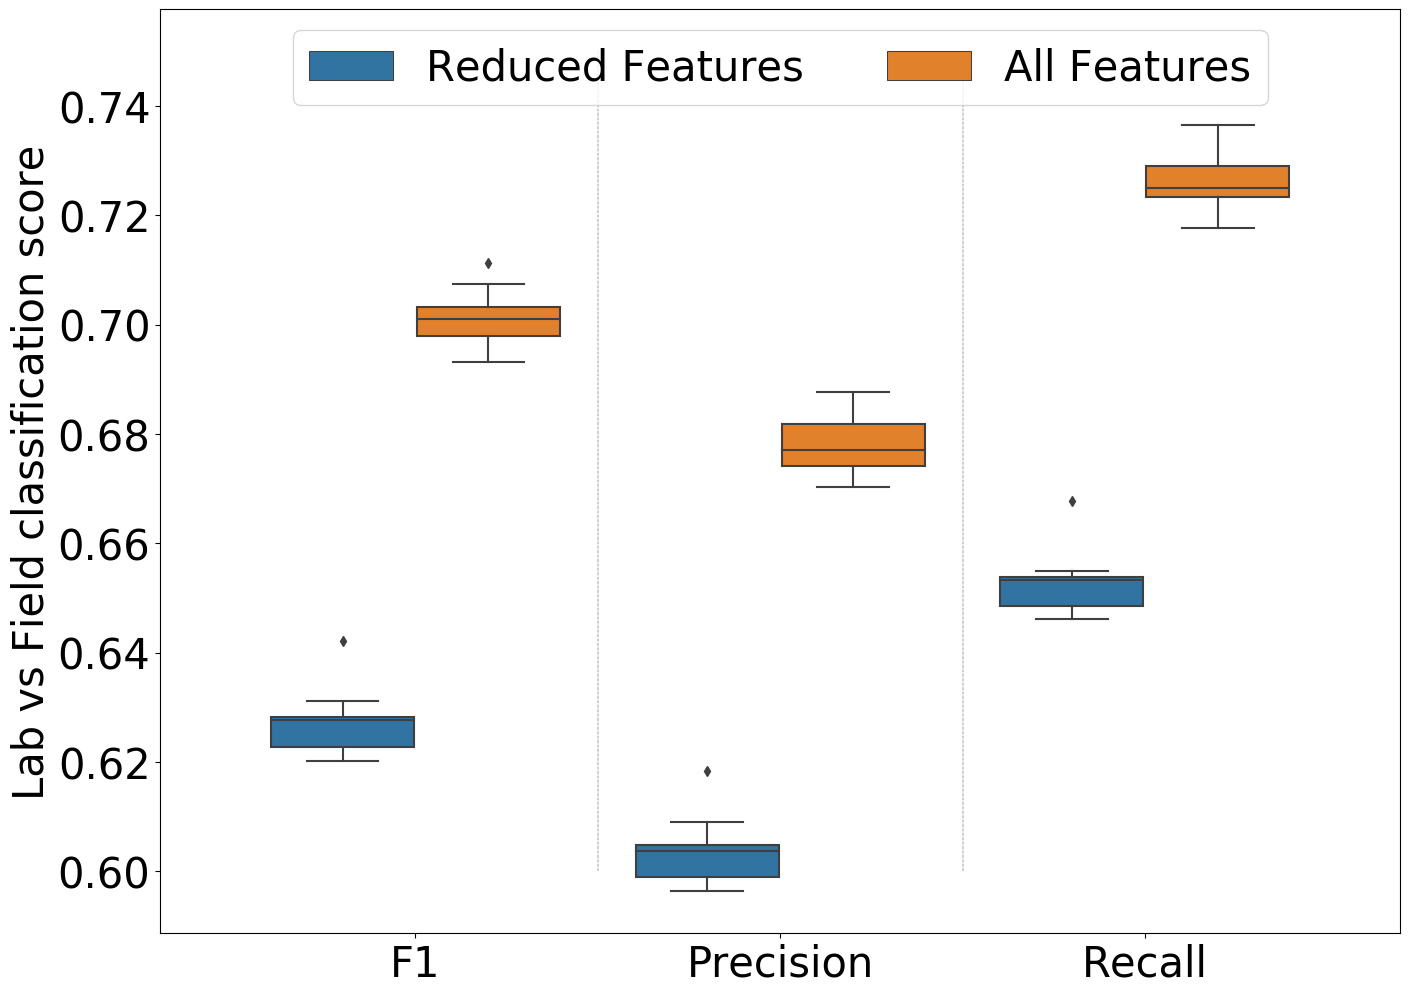

Lab vs Field classification score
Feature space                                                
All Features     F1                                  0.701157
                 Precision                           0.677862
                 Recall                              0.726115
Reduced Features F1                                  0.627454
                 Precision                           0.603899
                 Recall                              0.652923

In [7]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
results = pickle.load(open('lab.p','rb')) + pickle.load(open('field.p','rb'))
confs = [a[0] for a in results]

conf = np.zeros((2,2))
for a in confs:
    conf+=a

b =np.array([np.array(a[1:-1]) for a in results])
c = ['Reduced']*10+['Original']*10

# plt.boxplot(b)
df = []
score = ['F1','Precision','Recall']
labfield = ['Reduced Features']*10+['All Features']*10
for i,a in enumerate(b):
    for j,c in enumerate(a):
        df.append([score[j],a[j],labfield[i]])

df = pd.DataFrame(df,columns=['','Lab vs Field classification score','Feature space'])


sns.set(font_scale=3)
plt.style.use('default')
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(16,12))
sns.boxplot(x='',y='Lab vs Field classification score',hue='Feature space',data=df)
plt.vlines(.5,.6,.75,linestyle='-.',linewidth=.3)
plt.vlines(1.5,.6,.75,linestyle='-.',linewidth=.3)
plt.legend(loc='upper center',ncol=2)
plt.savefig('../lab_to_field_features.pdf')
plt.show()
df.groupby(['Feature space','']).mean()

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.core.window import _flex_binary_moment, _Rolling_and_Expanding
def weighted_mean(self, weights, **kwargs):
    weights = self._shallow_copy(weights)
    window = self._get_window(weights)

    def _get_weighted_mean(X, Y):
        X = X.astype('float64')
        Y = Y.astype('float64')
        sum_f = lambda x: x.rolling(window, self.min_periods, center=self.center).sum(**kwargs)
        return sum_f(X * Y) / sum_f(Y)

    return _flex_binary_moment(self._selected_obj, weights._selected_obj,
                               _get_weighted_mean, pairwise=True)

_Rolling_and_Expanding.weighted_mean = weighted_mean
# a['hr_weighted'] = a['hr'].rolling(window = 7).weighted_mean(a['quality'])
# clf_lab = pickle.load(open('../models/labvsfield1.p','rb'))
def dump_data(directory_ema,directory1,directory2,f):
    if f not in os.listdir(directory_ema):
        return 0
    data = pickle.load(open(directory1+f,'rb'))
    a = data[0]
    this_participant = []
    stress_all = a[['time','ltime','user','final_feature_matrix','stress_likelihood_ppg_qual','stress_likelihood_ppg_no_norm_qual',
                    'stress_likelihood_ppg_no_norm_no_qual','stress_likelihood_ppg_no_norm_qual_all_features',
                    'stress_likelihood_ppg_no_norm_no_qual_all_features',
                    'quality_mag','day','activity','hand','rr_weighted_features','60','100','60_all','100_all']].dropna()
    feature_matrix = np.array(list(stress_all['final_feature_matrix']))
#     index = np.array([0,1,4,5,6,8])
#     probs = clf_lab.predict_proba(np.nan_to_num(feature_matrix)[:,index])[:,1]
#     stress_all['probs'] = probs
    stress_all['hr'] = stress_all['rr_weighted_features'].apply(lambda a:a[-5])
    stress_days = [a for i,a in stress_all.groupby(['hand','day'],as_index=False) if a.shape[0]>180]
    _Rolling_and_Expanding.weighted_mean = weighted_mean
    for a in stress_days:
        a = a.sort_values('time').reset_index(drop=True)
        a['stress_likelihood_ppg_qual_weighted'] = a['stress_likelihood_ppg_qual'].rolling(window = 5).weighted_mean(a['quality_mag'])
        a['stress_likelihood_ppg_no_norm_qual_weighted'] = a['stress_likelihood_ppg_no_norm_qual'].rolling(window = 5).weighted_mean(a['quality_mag'])
        a['stress_likelihood_ppg_no_norm_qual_all_features_weighted'] = a['stress_likelihood_ppg_no_norm_qual_all_features'].rolling(window = 5).weighted_mean(a['quality_mag'])
        a['stress_likelihood_ppg_no_norm_no_qual_weighted'] = a['stress_likelihood_ppg_no_norm_no_qual'].rolling(window = 5).weighted_mean(a['quality_mag'])
        a['stress_likelihood_ppg_no_norm_no_qual_all_features_weighted'] = a['stress_likelihood_ppg_no_norm_no_qual'].rolling(window = 5).weighted_mean(a['quality_mag'])
        a['qual'] = a['quality_mag'].rolling(window = 7).weighted_mean(a['quality_mag'])
        a['hr'] = a['hr'].rolling(window = 7).weighted_mean(a['quality_mag'])
        this_participant.append(a)
    if len(this_participant)==0:
        return 0
    data = pd.concat(this_participant)
    ema = pickle.load(open(directory_ema+f,'rb'))
    ema = ema.sort_values('score').reset_index(drop=True)
    if ema.shape[0]<10:
        return 0
    ema['label'][ema['score']<=np.mean(ema['score'])] = 0
    ema['label'][ema['score']>np.mean(ema['score'])] = 1
    if len(ema['label'].unique())==1:
        return 0
    score_values = ema['score'].values
    diffs = np.array([0]+list(np.diff(np.array(ema['score'].values))))
    ind_max = np.argmax(diffs)
    if ind_max<3:
        return 0
    ema['label1'] = [0]*(ind_max-1) + [1]*(ema.shape[0]-ind_max+1)
#     ema['happy'] = ema['all_scores'].apply(lambda a:a[0])
#     ema['joyful'] = ema['all_scores'].apply(lambda a:a[1])
#     ema['nervous'] = ema['all_scores'].apply(lambda a:a[2])
#     ema['sad'] = ema['all_scores'].apply(lambda a:a[3])
#     ema['angry'] = ema['all_scores'].apply(lambda a:a[4])
#     labels = ema[['happy','joyful','nervous','sad','angry']].values
#     for j in range(labels.shape[1]):
#         t = labels[:,j]
#         t[t<=np.mean(t)] = 0
#         t[t!=0] = 1
#         labels[:,j] = t
#     labels = np.sum(labels,axis=1)
#     labels[labels<=2] = 0
#     labels[labels!=0] = 1
#     ema['label'] = labels
#     ind_max = np.argmax(diff)
#     if ind_max<3:
#         continue
#     ema['label'] = [0]*(ind_max-1) + [1]*(ema.shape[0]-ind_max+1)
#     plt.figure(figsize=(16,8))
# #     plt.hist(data['stress_likelihood_ecg'])
#     plt.hist(data['stress_likelihood_ppg_qual'])
#     plt.show()
#     plt.figure(figsize=(18,10))
#     plt.hist(data['stress_likelihood_ppg_qual'],50)
#     plt.show()
    pickle.dump([data,ema],open(directory2+f,'wb'))
    return 0

directory1 = '../../cc3/rice_data/after_computation/ecg_ppg_final_day_5_v6/'
directory2 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_final_weighted_day_5_v6/'
if not os.path.isdir(directory2):
    os.makedirs(directory2)
directory_ema = '../../cc3/rice_data/ecg_ppg_ema_final/'
from joblib import Parallel,delayed
output = Parallel(n_jobs=30,verbose=3)(delayed(dump_data)(directory_ema,directory1,directory2,f) for f in os.listdir(directory1) if f[-1]=='p')    
# output = [dump_data(directory_ema,directory1,directory2,f) for f in os.listdir(directory1) if f[-1]=='p']   
#         plt.figure(figsize=(18,10))
#         plt.plot(a['time'],a['stress_likelihood_ppg_qual'],'*-r')
#         plt.plot(a['time'],a['hr']/np.max(a['hr']),'o-c')
#         plt.title(np.max(a['hr']))
#         plt.bar(a['time'],a['qual'],50)
#         plt.show()

In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from pandas.core.window import _flex_binary_moment, _Rolling_and_Expanding
import matplotlib.pyplot as plt
directory2 = '../../cc3/rice_data/after_ema_parsing/ecg_ppg_final_weighted_day_5_v6/'
count = 0
df_col = []
ema_day = []
for f in os.listdir(directory2):
    if f[-1]!='p':
        continue
    data,ema = pickle.load(open(directory2+f,'rb'))
    if ema.shape[0]<10:
        continue
#     print(ema['label'].unique())
    for day in ema['day'].unique():
        ema_day.append(ema[ema.day==day])
        if ema_day[-1].shape[0]<1:
            ema_day = ema_day[:-1]
            continue
        if data[data.day==day]['stress_likelihood_ppg_qual'].dropna().shape[0]<30:
            ema_day = ema_day[:-1]
            continue
        df_col.append(data[data.day==day])
#         count+=ema_day[-1].shape[0]


In [5]:
from joblib import Parallel,delayed
import numpy as np
def get_data_data(duration,df_col,ema_day):
    all_data = []
    all_emas = []
    all_users = []
    hands = []
    for i in range(len(df_col)):
        data = df_col[i].sort_values('time').reset_index(drop=True)
        ema = ema_day[i].sort_values('time').reset_index(drop=True)
        for hand in ['left','right']:
            for j,row in ema.iterrows():
                temp_data = data[(data.time>=row['time']-duration*60) & (data.time<row['time']) & (data.hand==hand)].sort_values('time').reset_index(drop=True)
                print(temp_data.columns)
                if duration<=35:
                    min_length = 4
                else:
                    min_length = 10
                if duration<=35:
                    min_duration = 4
                else:
                    min_duration = 10
                
                if temp_data.shape[0]>min_length and temp_data['time'].values[-1]-temp_data['time'].values[0]>min_duration:
                    all_data.append(temp_data[['stress_likelihood_ppg_qual',
                                               'stress_likelihood_ppg_no_norm_qual',
                                               'stress_likelihood_ppg_no_norm_no_qual',
                                               'stress_likelihood_ppg_no_norm_qual_all_features',
                                               'stress_likelihood_ppg_no_norm_no_qual_all_features',
                                               'stress_likelihood_ppg_no_norm_qual_weighted',
                                               'stress_likelihood_ppg_qual_weighted',
                                               'stress_likelihood_ppg_no_norm_no_qual_weighted',
                                               'stress_likelihood_ppg_no_norm_qual_all_features_weighted',
                                               'stress_likelihood_ppg_qual_weighted',
                                               'stress_likelihood_ppg_no_norm_no_qual_all_features_weighted',
                                               'quality_mag']])
                    all_emas.append(row)
                    all_users.append(row['user'])
                    hands.append(hand)
    return [duration,all_data,all_emas,all_users,hands]
data_data = Parallel(n_jobs=30,verbose=3)(delayed(get_data_data)(duration,df_col,ema_day) for duration in np.arange(10,65,5))
# [get_data_data(duration,df_col,ema_day) for duration in np.arange(5,225,10)]
pickle.dump(data_data,open('../data/data_emas_all_duration_day_v6.p','wb'))
    

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  11 | elapsed:   25.3s remaining:   44.3s
[Parallel(n_jobs=30)]: Done   8 out of  11 | elapsed:   39.8s remaining:   14.9s
[Parallel(n_jobs=30)]: Done  11 out of  11 | elapsed:   51.6s finished


In [ ]:
# import numpy as np
# import pylab as pb
# import GPy 
# %pylab inline
# def get_predictions(X,Y,error):
#     X = (X - np.mean(X))/np.std(X)
#     mm = np.mean(Y)
#     ss = np.std(Y)
#     Y = (Y-np.mean(Y))/ss
#     kern =  GPy.kern.RBF(input_dim=1) + GPy.kern.MLP(1) 
#     Y_meta = {'output_index':np.arange(len(Y))[:,None]}
#     m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern,Y_metadata=Y_meta)
#     m['.*het_Gauss.variance'] = np.abs(error)[:,None] #Set the noise parameters to the error in Y
#     m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
#     m.optimize()
#     preds,varss  = m.predict(m.X,full_cov=False,Y_metadata=None,kern=None,likelihood=None,include_likelihood=False)
#     return preds*ss+mm,varss
len(df_col)

In [ ]:
from copy import deepcopy
def save_pdf(data,ema,i):
    for hand in ['left','right']:
        g= deepcopy(data[data.hand==hand]).dropna()
#         g['hour'] = g['ltime'].apply(lambda a:int(a.hour))
#         print(g.hour.values)
#         g = g[(g.hour>=6) & (g.hour<20)]
        if g.shape[0]<100:
            continue
        g['ltime_str'] = g['ltime'].apply(lambda a:a.strftime("%H:%M"))
        preds,varss = get_predictions(g['time'].values,g['stress_likelihood_ppg_qual'].values,(1.1-g['quality_mag'].values)/2)
        plt.figure(figsize=(19,10))
        plt.title(g['user'].values[0] +'--'+ g['day'].values[0]+'--'+g['hand'].values[0]+' wrist')
        plt.plot((g['time']-np.min(g['time']))/60,g['stress_likelihood_ppg_qual'],'*-r',linewidth=1,label='Stress Likelihood')
        plt.plot((g['time']-np.min(g['time']))/60,preds,'*-k',linewidth=3,label='Stress Likelihood Post Processed by GP')
#         plt.plot((g['time']-np.min(g['time']))/60,g['hr']/60,'s-g',linewidth=3,label='Normalized Heart Rate w.r.t. 60 BPM')
        #         plt.plot((g['time']-np.min(g['time']))/60,g['stress_likelihood_ppg'],'y',linestyle='--')
        plt.bar((g['time']-np.min(g['time']))/60,g['quality_mag'],4,alpha=1,label='Minute Level Quality Metric')
        plt.bar((g['time']-np.min(g['time']))/60,g['probs']*-1,4,alpha=1,label='LAB(0) vs Field(-1)')
        #         for j,row in ema.iterrows():
        #             print(row['label'])
        #             if np.int64(row['label'])==1:
        row = ema[ema.label==1]
        if row.shape[0]>0:
            plt.bar((row['time']-np.min(g['time']))/60,[1]*row.shape[0],10,alpha=1,label='Stress EMA',color='darkred')
        #             else:
        row = ema[ema.label==0]
        if row.shape[0]>0:
            plt.bar((row['time']-np.min(g['time']))/60,[1]*row.shape[0],10,alpha=1,label='Not Stress EMA',color='darkgreen')
        plt.legend(ncol=5)
        plt.xticks(np.array((g['time']-np.min(g['time']))/60)[np.arange(g.shape[0])%10==0],g['ltime_str'][np.arange(g.shape[0])%10==0],rotation=60)
        plt.ylim([-1.3,1.3])
        plt.xlabel('Time of Day')
    #     plt.ylabel('Likelihood Values')
        plt.savefig('../pics_day/'+g['user'].values[0] +'--'+ g['day'].values[0]+'--'+g['hand'].values[0]+' wrist'+'.pdf',dps=1e6)
        plt.close('all')
    return 0
from joblib import Parallel,delayed
ouput = Parallel(n_jobs=-1,verbose=2)(delayed(save_pdf)(df_col[i].sort_values('time').reset_index(drop=True),
                                                        ema_day[i].sort_values('time').reset_index(drop=True),
                                                       i) for i in range(len(df_col)))
# ouput = [save_pdf(df_col[i].sort_values('time').reset_index(drop=True),
#                                                         ema_day[i].sort_values('time').reset_index(drop=True),
#                                                        i) for i in range(len(df_col))]
    #         plt.bar((g['time']-np.min(g['time']))/60,g['activity_f'],.2,alpha=.5,color='r')
#     plt.show()

In [ ]:
from PyPDF2 import PdfFileMerger, PdfFileReader
import os
filenames = os.listdir('../pics_day/')
filenames = sorted([a for a in filenames if a[-1]=='f'])

merger = PdfFileMerger()
for filename in filenames:
    merger.append(PdfFileReader(open('../pics_day/'+filename, 'rb')))

merger.write("result-output_daywise_normalization.pdf")